In [37]:
# 1.a
import numpy as np

def max_lloyd_quantizer(data, levels, meps):
    """
    Implements the iterative Max-Lloyd algorithm for image quantization.
    
    Inputs:
        data: One channel image in a uint8 format.
        levels: Number of wanted different representation levels.
        meps: Minimal required approximation.
    
    Outputs:
        dataout: The image after quantization.
        distortion: A vector containing the average distortion in each iteration.
        QL: A vector containing the different representation levels.
    """
    # Convert data to double format
    data = data.astype(np.float64)

    # Initialize quantizer levels randomly within the data range
    min_val, max_val = np.min(data), np.max(data)
    QL = np.random.uniform(min_val, max_val, levels)

    # Initialize stopping condition and storage for distortions
    max_iterations = 100  # Reasonable upper limit
    distortion = []
    prev_distortion = float('inf')

    for _ in range(max_iterations):
        # Step 1: Assign each pixel to the closest quantization level
        indices = np.argmin(np.abs(data[..., None] - QL), axis=-1)

        # Step 2: Compute new quantizer levels (centroids)
        new_QL = np.array([
        np.mean(data[indices == k]) if np.any(indices == k) else QL[k]  # Keep previous value instead of random
        for k in range(levels)
        ])
        
        # Step 3: Compute distortion
        current_distortion = np.mean((data - new_QL[indices]) ** 2)
        distortion.append(current_distortion)

        # Check stopping condition
        if abs(prev_distortion - current_distortion) / prev_distortion < meps:
            break

        # Update quantizer levels and previous distortion
        QL = new_QL
        prev_distortion = current_distortion

    # Generate quantized image
    dataout = QL[indices].astype(np.uint8)  # Convert back to uint8 for display

    return dataout, np.array(distortion), QL

C:\Users\ompal\anaconda3\envs\anat_env\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


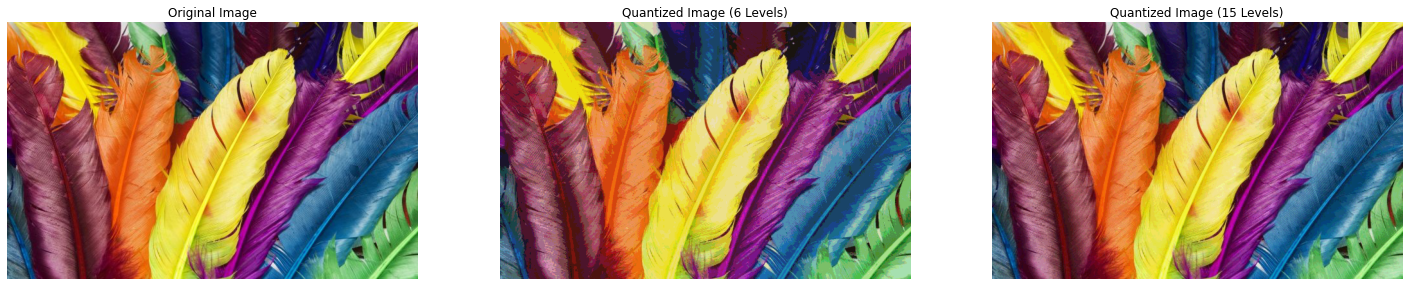

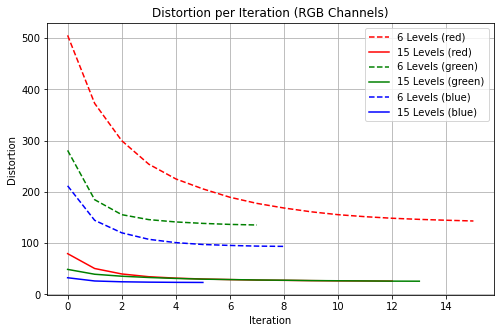

In [45]:
# 1.b
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in RGB format
image_path = "C:/Users/ompal/Documents/colorful.jpg"  # Adjust path if needed
image = cv2.imread(image_path)  # Load the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Function to apply quantization to each channel
def apply_quantization(image, levels, meps):
    quantized_channels = []
    distortions = []

    for c in range(3):  # Iterate over R, G, B channels
        quantized, distortion, _ = max_lloyd_quantizer(image[:, :, c], levels, meps)
        quantized_channels.append(quantized)
        distortions.append(distortion)

    quantized_image = np.stack(quantized_channels, axis=-1)
    return quantized_image, distortions

# Define parameters
meps = 0.01

# Apply quantization with 6 levels
quantized_img_6, distortion_6 = apply_quantization(image, levels=6, meps=meps)

# Apply quantization with 15 levels
quantized_img_15, distortion_15 = apply_quantization(image, levels=15, meps=meps)

# Display the original and quantized images
fig, axes = plt.subplots(1, 3, figsize=(25, 15))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(quantized_img_6)
axes[1].set_title("Quantized Image (6 Levels)")
axes[1].axis("off")

axes[2].imshow(quantized_img_15)
axes[2].set_title("Quantized Image (15 Levels)")
axes[2].axis("off")

plt.show()

# Plot the distortion for each channel
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["red", "green", "blue"]
for i, color in enumerate(colors):
    ax.plot(distortion_6[i], linestyle="--", label=f"6 Levels ({color})", color=color)
    ax.plot(distortion_15[i], label=f"15 Levels ({color})", color=color)

ax.set_title("Distortion per Iteration (RGB Channels)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Distortion")
ax.legend()
ax.grid()
plt.show()

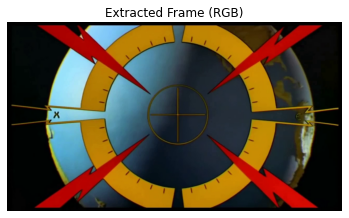

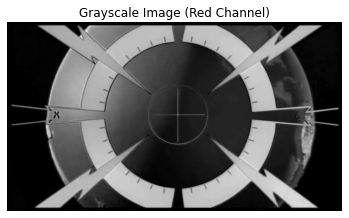

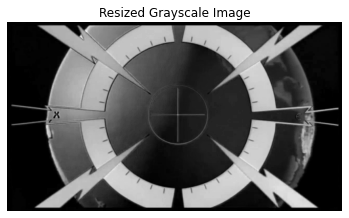

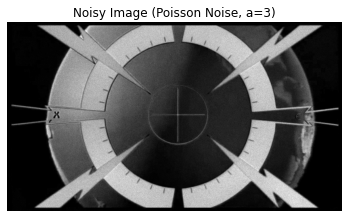

In [51]:
# 2.a
# Step 1: Extract a frame from the video
import cv2
import numpy as np

# Load the video
video_path = "C:/Users/ompal/Documents/Flash Gordon Trailer.mp4"  # Adjust path if needed
cap = cv2.VideoCapture(video_path)

# Set the time to extract the frame
fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
frame_number = int(fps * 20)  # Extract a frame at 20 seconds

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Failed to extract frame from video")

# Convert frame from BGR to RGB for proper visualization
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the extracted frame
import matplotlib.pyplot as plt
plt.imshow(frame_rgb)
plt.title("Extracted Frame (RGB)")
plt.axis("off")
plt.show()

# Step 2: Convert to Grayscale Using a Specific Channel
# Choose one channel (Red or Green)
chosen_channel = frame_rgb[:, :, 0]  # Red channel (use frame_rgb[:, :, 1] for Green)

# Display the grayscale channel
plt.imshow(chosen_channel, cmap="gray")
plt.title("Grayscale Image (Red Channel)")
plt.axis("off")
plt.show()

# Step 3: Resize the Image by a Factor of 2
# Resize image by a factor of 2
resized_image = cv2.resize(chosen_channel, (chosen_channel.shape[1] // 2, chosen_channel.shape[0] // 2))

# Display the resized image
plt.imshow(resized_image, cmap="gray")
plt.title("Resized Grayscale Image")
plt.axis("off")
plt.show()

# Step 4: Implement the Poisson Noise Function
def poisson_noisy_image(X, a):
    """
    Creates a Poisson noisy image.
    :param X: The original image, np.array of size [H x W] and of type uint8.
    :param a: Number of photons scalar factor.
    :return: Y: The noisy image, np.array of size [H x W] and of type uint8.
    """
    # Convert to float
    X = X.astype(np.float64)

    # Scale image by a to convert to photon units
    X = X * a

    # Apply Poisson noise
    noisy_X = np.random.poisson(X)

    # Scale back by a
    noisy_X = noisy_X / a

    # Clip values to [0,255] and convert back to uint8
    Y = np.clip(noisy_X, 0, 255).astype(np.uint8)

    return Y

# Step 5: Apply Poisson noise with a = 3
noisy_image = poisson_noisy_image(resized_image, a=3)

# Display the noisy image
plt.imshow(noisy_image, cmap="gray")
plt.title("Noisy Image (Poisson Noise, a=3)")
plt.axis("off")
plt.show()

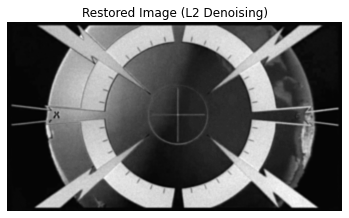

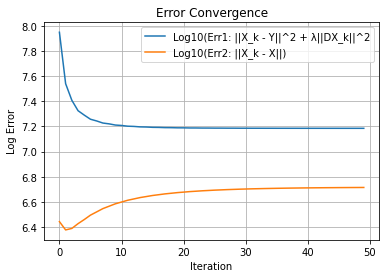

In [55]:
# 2.b
import numpy as np
import cv2
import matplotlib.pyplot as plt

def denoise_by_l2(Y, X, num_iter, lambda_reg):
    """
    L2 image denoising using steepest descent.
    
    :param Y: The noisy image, np.array of size [H x W] and of type uint8.
    :param X: The original image, np.array of size [H x W] and of type uint8.
    :param num_iter: The number of iterations for the algorithm.
    :param lambda_reg: The regularization parameter.
    
    :return: 
        Xout: The restored image, np.array of size [H x W].
        Err1: The error between Xk at every iteration and Y. (np.array of size [num_iter])
        Err2: The error between Xk at every iteration and X. (np.array of size [num_iter])
    """

    # Convert images to float64 for processing
    Y = Y.astype(np.float64)
    X = X.astype(np.float64)

    # Get image dimensions
    H, W = Y.shape

    # Initialize X_k with Y
    X_k = Y.copy()

    # Define Laplacian kernel for D
    D_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float64)

    # Flatten images to column-major order (Fortran-style)
    Y_vec = Y.flatten(order='F')
    X_vec = X.flatten(order='F')
    X_k_vec = X_k.flatten(order='F')

    # Store errors
    Err1 = np.zeros(num_iter)
    Err2 = np.zeros(num_iter)

    # Steepest Descent iterations
    for k in range(num_iter):
        # Reshape X_k to matrix for convolution
        X_k_mat = np.reshape(X_k_vec, (H, W), order='F')

        # Compute gradient G_k = (I + λDᵀD)X_k - Y
        DX_k = cv2.filter2D(X_k_mat, -1, D_kernel, borderType=cv2.BORDER_REPLICATE)
        DTDX_k = cv2.filter2D(DX_k, -1, D_kernel, borderType=cv2.BORDER_REPLICATE)

        G_k_mat = (X_k_mat - Y) + lambda_reg * DTDX_k
        G_k_vec = G_k_mat.flatten(order='F')

        # Compute step size μ_k = (G_kᵀ G_k) / (G_kᵀ (I + λDᵀD) G_k)
        num = np.dot(G_k_vec.T, G_k_vec)

        G_k_mat_filtered = (G_k_mat + lambda_reg * cv2.filter2D(
            cv2.filter2D(G_k_mat, -1, D_kernel, borderType=cv2.BORDER_REPLICATE),
            -1, D_kernel, borderType=cv2.BORDER_REPLICATE
        ))

        denom = np.dot(G_k_vec.T, G_k_mat_filtered.flatten(order='F'))

        mu_k = num / denom if denom != 0 else 0  # Avoid division by zero

        # Update X_k
        X_k_vec = X_k_vec - mu_k * G_k_vec

        # Compute errors
        Err1[k] = np.dot((X_k_vec - Y_vec).T, (X_k_vec - Y_vec)) + lambda_reg * np.dot(DX_k.flatten(order='F').T, DX_k.flatten(order='F'))
        Err2[k] = np.dot((X_k_vec - X_vec).T, (X_k_vec - X_vec))

    # Reshape X_k_vec back to image form
    Xout = np.reshape(X_k_vec, (H, W), order='F')

    return Xout, Err1, Err2

# Apply the function on the noisy image from 2.a
lambda_reg = 0.5
num_iters = 50

X_restored, Err1, Err2 = denoise_by_l2(noisy_image, resized_image, num_iters, lambda_reg)

# Display restored image
plt.imshow(X_restored, cmap='gray')
plt.title("Restored Image (L2 Denoising)")
plt.axis("off")
plt.show()

# Plot the logarithmic errors
plt.figure()
plt.plot(np.log10(Err1), label='Log10(Err1: ||X_k - Y||^2 + λ||DX_k||^2')
plt.plot(np.log10(Err2), label='Log10(Err2: ||X_k - X||)')
plt.xlabel("Iteration")
plt.ylabel("Log Error")
plt.title("Error Convergence")
plt.legend()
plt.grid()
plt.show()


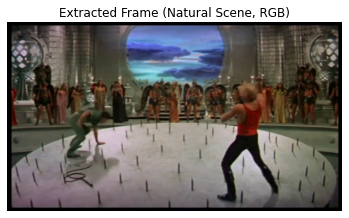

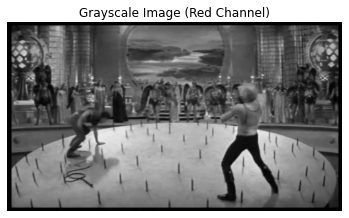

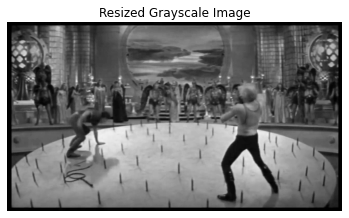

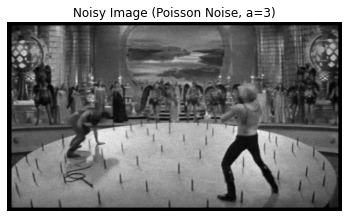

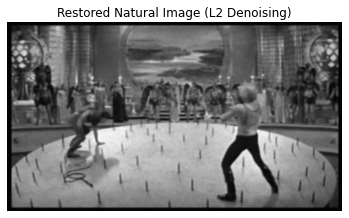

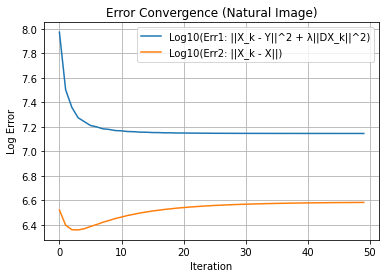

In [57]:
# 2.c
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Extract a new frame from the video (from 00:38-00:39)
video_path = "C:/Users/ompal/Documents/Flash Gordon Trailer.mp4"  # Adjust path if needed
cap = cv2.VideoCapture(video_path)

# Set the time to extract the frame (choose a frame in the range 38-39 seconds)
fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
frame_number = int(fps * 38)  # Extract a frame at 38 seconds

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Failed to extract frame from video")

# Convert frame from BGR to RGB for proper visualization
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the extracted frame
plt.imshow(frame_rgb)
plt.title("Extracted Frame (Natural Scene, RGB)")
plt.axis("off")
plt.show()

# Convert to Grayscale Using a Specific Channel
# Choose one channel (Red or Green)
chosen_channel = frame_rgb[:, :, 0]  # Red channel (use frame_rgb[:, :, 1] for Green)

# Display the grayscale channel
plt.imshow(chosen_channel, cmap="gray")
plt.title("Grayscale Image (Red Channel)")
plt.axis("off")
plt.show()

# Resize the Image by a Factor of 2
resized_image = cv2.resize(chosen_channel, (chosen_channel.shape[1] // 2, chosen_channel.shape[0] // 2))

# Display the resized image
plt.imshow(resized_image, cmap="gray")
plt.title("Resized Grayscale Image")
plt.axis("off")
plt.show()

# Apply Poisson Noise
def poisson_noisy_image(X, a):
    """
    Creates a Poisson noisy image.
    :param X: The original image, np.array of size [H x W] and of type uint8.
    :param a: Number of photons scalar factor.
    :return: Y: The noisy image, np.array of size [H x W] and of type uint8.
    """
    # Convert to float
    X = X.astype(np.float64)

    # Scale image by a to convert to photon units
    X = X * a

    # Apply Poisson noise
    noisy_X = np.random.poisson(X)

    # Scale back by a
    noisy_X = noisy_X / a

    # Clip values to [0,255] and convert back to uint8
    Y = np.clip(noisy_X, 0, 255).astype(np.uint8)

    return Y

# Apply Poisson noise with a = 3
noisy_image = poisson_noisy_image(resized_image, a=3)

# Display the noisy image
plt.imshow(noisy_image, cmap="gray")
plt.title("Noisy Image (Poisson Noise, a=3)")
plt.axis("off")
plt.show()

# Denoising the Natural Image 
def denoise_by_l2(Y, X, num_iter, lambda_reg):
    """
    L2 image denoising using steepest descent.
    
    :param Y: The noisy image, np.array of size [H x W] and of type uint8.
    :param X: The original image, np.array of size [H x W] and of type uint8.
    :param num_iter: The number of iterations for the algorithm.
    :param lambda_reg: The regularization parameter.
    
    :return: 
        Xout: The restored image, np.array of size [H x W].
        Err1: The error between Xk at every iteration and Y. (np.array of size [num_iter])
        Err2: The error between Xk at every iteration and X. (np.array of size [num_iter])
    """

    # Convert images to float64 for processing
    Y = Y.astype(np.float64)
    X = X.astype(np.float64)

    # Get image dimensions
    H, W = Y.shape

    # Initialize X_k with Y
    X_k = Y.copy()

    # Define Laplacian kernel for D
    D_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float64)

    # Flatten images to column-major order (Fortran-style)
    Y_vec = Y.flatten(order='F')
    X_vec = X.flatten(order='F')
    X_k_vec = X_k.flatten(order='F')

    # Store errors
    Err1 = np.zeros(num_iter)
    Err2 = np.zeros(num_iter)

    # Steepest Descent iterations
    for k in range(num_iter):
        # Reshape X_k to matrix for convolution
        X_k_mat = np.reshape(X_k_vec, (H, W), order='F')

        # Compute gradient G_k = (I + λDᵀD)X_k - Y
        DX_k = cv2.filter2D(X_k_mat, -1, D_kernel, borderType=cv2.BORDER_REPLICATE)
        DTDX_k = cv2.filter2D(DX_k, -1, D_kernel, borderType=cv2.BORDER_REPLICATE)

        G_k_mat = (X_k_mat - Y) + lambda_reg * DTDX_k
        G_k_vec = G_k_mat.flatten(order='F')

        # Compute step size μ_k
        num = np.dot(G_k_vec.T, G_k_vec)

        G_k_mat_filtered = (G_k_mat + lambda_reg * cv2.filter2D(
            cv2.filter2D(G_k_mat, -1, D_kernel, borderType=cv2.BORDER_REPLICATE),
            -1, D_kernel, borderType=cv2.BORDER_REPLICATE
        ))

        denom = np.dot(G_k_vec.T, G_k_mat_filtered.flatten(order='F'))

        mu_k = num / denom if denom != 0 else 0  # Avoid division by zero

        # Update X_k
        X_k_vec = X_k_vec - mu_k * G_k_vec

        # Compute errors
        Err1[k] = np.dot((X_k_vec - Y_vec).T, (X_k_vec - Y_vec)) + lambda_reg * np.dot(DX_k.flatten(order='F').T, DX_k.flatten(order='F'))
        Err2[k] = np.dot((X_k_vec - X_vec).T, (X_k_vec - X_vec))

    # Reshape X_k_vec back to image form
    Xout = np.reshape(X_k_vec, (H, W), order='F')

    return Xout, Err1, Err2

# Apply the function on the noisy natural image
lambda_reg = 0.5
num_iters = 50

X_restored, Err1, Err2 = denoise_by_l2(noisy_image, resized_image, num_iters, lambda_reg)

# Display restored image
plt.imshow(X_restored, cmap='gray')
plt.title("Restored Natural Image (L2 Denoising)")
plt.axis("off")
plt.show()

# Plot the logarithmic errors
plt.figure()
plt.plot(np.log10(Err1), label='Log10(Err1: ||X_k - Y||^2 + λ||DX_k||^2)')
plt.plot(np.log10(Err2), label='Log10(Err2: ||X_k - X||)')
plt.xlabel("Iteration")
plt.ylabel("Log Error")
plt.title("Error Convergence (Natural Image)")
plt.legend()
plt.grid()
plt.show()